In [19]:
# 导入函数库和数据
import pandas as pd
import numpy as np
import folium
import math
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from scipy.interpolate import interp1d
from folium.plugins import MarkerCluster
%run Tools.py # 直接在cell中加载py文件，这样好像效率更高
# from Tools import wgs84_to_gcj02
# from Tools import denoise
# from Tools import stay_points

Data_row = pd.read_csv("tmp_track_analysis_sample_data.csv",header=0)
Vin_name = ['wqmbpgahavumbageb',
'wqmbpgahavumbedfb',
'wqmbpgahavumabejj',
'wqmbpgahavumbdicj',
'wqmbpgahavumbfcec',
'wqmbpgahavumajehd',
'wqmbpgahavumabeif',
'wqmbpgahavumbbcba',
'wqmbpgahavumajdgb',
'wqmbpgahavumbfefc']

In [ ]:
# 一、按时间戳对数据排序，再按车主标识分离数据
# 1.WGS84坐标系转GCJ-02坐标系,同时剔除
length = Data_row.shape[0]
for i in range(length):
    Data_row["longitude"][i] = wgs84_to_gcj02(Data_row["longitude"][i],Data_row["latitude"][i])[0]
    Data_row["latitude"][i] = wgs84_to_gcj02(Data_row["longitude"][i],Data_row["latitude"][i])[1]

# 2.对时间戳排序
Data_row["datetime"] = pd.to_datetime(Data_row["datetime"]) 
Data_row.sort_values(by = "datetime",ascending=True,inplace=True)

# 3.根据车主标识分离数据
Vin = {}
for i in range(length):
    Vin[Data_row["vin"][i]] = Vin.get(Data_row["vin"][i],0)+1

Vin_name, Vin_count= [],[]
for vin_name in Vin:
    Vin_name.append(vin_name)
    Vin_count.append(Vin[vin_name])

for i in range(len(Vin_name)):
    Data = pd.DataFrame(Data_row[Data_row["vin"]==Vin_name[i]].values, columns=Data_row.columns)
    Data.to_csv('Data/'+str(Vin_name[i])+'.csv')

# 可视化车主轨迹点数量
plt.barh(Vin_name,Vin_count)
plt.grid()
plt.show()

In [ ]:
# 利用小概率分布的思想选择噪声点阈值
# 读入示例数据
df = pd.read_csv("Data/wqmbpgahavumabeif.csv",header=0)
df["datetime"] = pd.to_datetime(df["datetime"]) 

Dis = np.array([])
length = df.shape[0]
i = 2
while i<length-2:
    dis = geodesic((df["latitude"][i], df["longitude"][i]), (df["latitude"][i-1], df["longitude"][i-1])).km
    time_gap = (df["datetime"][i]-df["datetime"][i-1]).seconds/3600
    speed_max = np.max([df["veh_speed"][i],df["veh_speed"][i-1]])
    dis_max = speed_max*time_gap
    Dis = np.append(Dis,dis-dis_max)
    if dis-dis_max>0.005: 
        lati = [df["latitude"][i-2], df["latitude"][i-1], df["latitude"][i+1], df["latitude"][i+2]]
        long = [df["longitude"][i-2], df["longitude"][i-1], df["longitude"][i+1], df["longitude"][i+2]]
        X0 = [1,2,4,5]
        fun_lati = interp1d(X0,lati, kind="cubic")
        fun_long = interp1d(X0,long, kind="cubic")
        dis1 = geodesic((fun_lati(3), fun_long(3)), (df["latitude"][i-1], df["longitude"][i-1])).km
        if dis1<1:
            df["latitude"][i] = fun_lati(3)
            df["longitude"][i] = fun_long(3)
            i = i+1
        else:
            df = pd.DataFrame(df.drop(labels=i).values,columns=df.columns)
            length = length-1
    else:
        i = i+1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


-0.00769960376148783
[ -842.83425208  -665.21451725  -636.49436801 ... 12752.11723122
 12752.11723122 12752.11723122]
0.07517377499356388


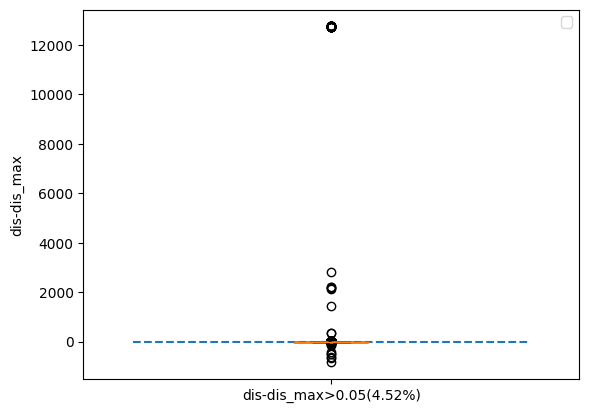

In [12]:
# 求尾部小概率
Dis = np.sort(Dis)
print(Dis[17500])
print(Dis)
for i in range(length-1):
    if Dis[i]>0.005:
        print((length-i-1)/(length-1))
        break

plt.boxplot(Dis,labels = ["dis-dis_max>0.05(4.52%)"])
plt.hlines(0.005, xmin=0.6,xmax=1.4, linestyle='--')
plt.ylabel("dis-dis_max")
plt.legend()
plt.show()

In [41]:
# 二、轨迹去噪（以wqmbpgahavumabeif.csv轨迹数据为例探索）
"""
数据噪声点的存在是难以避免的。当GPS定位因自身故障或外部信号干扰时，车辆轨迹数据就有可能出现噪声点（还有可能出现缺失记录的情况，
此处不作讨论）。

识别方法：噪声点简单理解即是与正常轨迹点相异的点，表现为前一轨迹点与噪声点的距离大于或者小于它与正常轨迹点的距离。显然我们并不知道正常轨迹点
的位置，因此只能利用间接的方法识别噪声点，具体如下：结合车速、时间间隔估算前一轨迹点与后一“正常轨迹点”的距离，将该距离与计算的前后两轨迹点
直线距离作比较，若计算距离与估算距离差值不大于某个阈值，则认为后一轨迹点是正常的，反之则为噪声点。
优点:简单高效且直观
缺点:当前后两轨迹点时间间隔较大时，根据车速所估算的距离可能存在较大误差，从而产生噪声点的误判。

拓展思路：是不是可以采取类似于异常检测的方法？怎么将其应用于轨迹数据的异常（噪声）检测？
"""
# 读入示例数据
df_sample = pd.read_csv("Data/wqmbpgahavumabeif.csv",header=0)
df_sample["datetime"] = pd.to_datetime(df_sample["datetime"]) 

# 1.噪声点识别探索
GPS = [[df_sample["latitude"][0],df_sample["longitude"][0]]] # 用于保存轨迹点经纬度
Flag = [0] # 用于记录轨迹点是否为噪声点
flag = 0 # 用于记录当下正常轨迹点的索引号
length = df_sample.shape[0]
for i in range(1,length): 
    """
    dis计算的是两轨迹点直线距离
    dis_max估算的是最大车速下的行驶距离，其中time_gap计算时间差（小时计），speed_max计算的是最大车速
    根据要求，只要dis-dis_max<0.005,则仍认为轨迹点的记录无误
    """
    dis = geodesic((df_sample["latitude"][i], df_sample["longitude"][i]), (df_sample["latitude"][flag], df_sample["longitude"][flag]) ).km
    time_gap = (df_sample["datetime"][i]-df_sample["datetime"][flag]).seconds/3600
    speed_max = np.max(df_sample["veh_speed"][flag:i+1])
    dis_max = speed_max*time_gap
    GPS.append([df_sample["latitude"][i],df_sample["longitude"][i]])
    if dis-dis_max>0.005: # 
        Flag.append(1)
    else:
        Flag.append(0)
        flag = i

# 噪声点可视化
map = folium.Map(location=GPS[0], zoom_start=15, attr='default',tiles =  'https://rt0.map.gtimg.com/tile?z={z}&x={x}&y={-y}') # 地图为腾讯地图
folium.PolyLine(  # 画轨迹线
    GPS,  
    weight=3,  
    color="green",  # 轨迹线的颜色为绿色
    opacity=0.5  
).add_to(map) 

length = len(GPS) # 画轨迹点
for i in range(1,length-1):
    if Flag[i]==1:
        folium.Marker(
        location = GPS[i], 
        icon=folium.Icon(color="red") # 噪声点颜色为红色
        ).add_to(map)

folium.Marker(location = GPS[0], popup="起点",icon=folium.Icon(color="blue")).add_to(map) # 把起始点添加到map里
folium.Marker(location = GPS[-1], popup="终点",icon=folium.Icon(color="blue")).add_to(map) # 把终点添加到map里
map.save("Maps/噪声点.HTML")  # 将结果以HTML形式保存到默认路径

"""
根据绘图结果来看，轨迹数据基本上都与地图上的道路线重合，若出现不重合的情况，则偏离较大的轨迹点往往是噪声点。
基于该情况，在采用上述方法进行噪声点识别时，基本上都能将偏离大的噪声点识别出来，但同时也容易将正常轨迹点识别为噪声点（如图中高速上轨迹点）。
"""

'\n根据绘图结果来看，轨迹数据基本上都与地图上的道路线重合，若出现不重合的情况，则偏离较大的轨迹点往往是噪声点。\n基于该情况，在采用上述方法进行噪声点识别时，基本上都能将偏离大的噪声点识别出来，但同时也容易将正常轨迹点识别为噪声点（如图中高速上轨迹点）。\n'

In [42]:
# 2.噪声点的替换
"""
在上述噪声点识别方法基础上，我们来谈论如何对噪声点进行替换：
(1)若噪声点位于近似直线的道路上，则可采取前后轨迹点均值填补的方法简单解决
(2)若噪声点位于道路转弯处， 则需要综合考虑前后若干组轨迹点的经纬度变化，此处我们采用三次样条插值法分别对经度和纬度进行插值，得到噪声点替换值
综合来看，采用插值法对噪声点进行替换比较合适，
(3) 需要注意的是，当连续出现噪声点时，插值的结果很可能并不好,特别当连续噪声点偏差很大时，我们就需要考虑删除该噪声点
"""

# 对示例数据进行噪声点插值并可视化
i = 2
while i<length-2:
    if Flag[i]==1:
        # 三次样条插值
        lati = [GPS[i-2][0], GPS[i-1][0], GPS[i+1][0], GPS[i+2][0]]
        long = [GPS[i-2][1], GPS[i-1][1], GPS[i+1][1], GPS[i+2][1]]
        X0 = [1,2,4,5]
        fun_lati = interp1d(X0,lati, kind="cubic")
        fun_long = interp1d(X0,long, kind="cubic")
        # 若插值后的点仍然是严重的噪声点，则对其作删除处理
        dis = geodesic((fun_lati(3), fun_long(3)), (GPS[i-1][0], GPS[i-1][1])).km
        if dis<1: # 此处设定填补轨迹点与上一轨迹点偏差不得超过1公里，这足以将轨迹数据中偏离极大的点剔除
            GPS[i][0] = fun_lati(3)
            GPS[i][1] = fun_long(3)
            i = i+1
        else:
            GPS.pop(i)
            Flag.pop(i)
            length = length-1
    else:
        i = i+1

map = folium.Map(location=GPS[0], zoom_start=15, attr='default',tiles =  'https://rt0.map.gtimg.com/tile?z={z}&x={x}&y={-y}') # 地图为腾讯地图
folium.PolyLine(  # 画轨迹线
    GPS,  
    weight=3,  
    color="black",  # 轨迹线的颜色为黑色
    opacity=0.5  
).add_to(map)

length = len(GPS) # 画轨迹点
for i in range(1,length-1):
    if Flag[i]==1:
        folium.Marker(
        location = GPS[i], 
        icon=folium.Icon(color="red") # 噪声点颜色为红色
        ).add_to(map)

folium.Marker(location = GPS[0], popup="起点",icon=folium.Icon(color="blue")).add_to(map) # 把起始点添加到map里
folium.Marker(location = GPS[-1], popup="终点",icon=folium.Icon(color="blue")).add_to(map) # 把终点添加到map里
map.save("Maps/噪声点1.HTML")  # 将结果以HTML形式保存到默认路径

In [ ]:
# 3.对所有车主进行去噪声处理

for i in range(len(Vin_name)):
    df = pd.read_csv("Data/"+str(Vin_name[i])+".csv")
    df["datetime"] = pd.to_datetime(df["datetime"])
    denoise(df).to_csv("Data_denoise/"+str(Vin_name[i])+".csv")

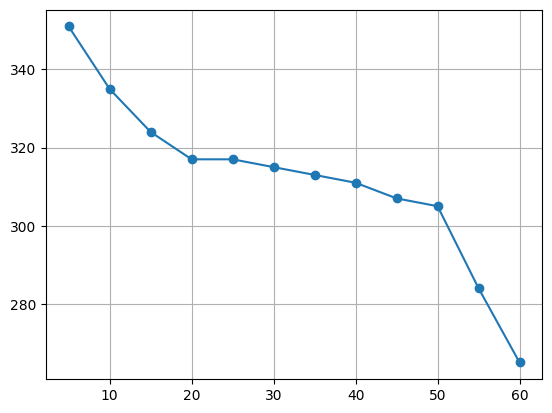

'\n由可视化结果，可初步看出该车主居住地为绿园区新奥蓝城15栋，其余常驻停留地点有绿园区金山红旗4S店，净月区北煦宾馆附近，停留点数目共计为24个，\n大多数显示为居住地。此外，由于记录时间为8月6日至10月23日，因而可推断该车主日常生活中并不热衷于开车上下班。\n'

In [14]:
# 三、提取停留点（同样以wqmbpgahavumbfefc.csv轨迹数据为例探索）
"""
对停留点的理解：在某个很小的区域范围内行动时间很长，最极端的即在某个点呆着一动不动很长时间。

针对车辆轨迹数据停留点的识别，我们采取的是依据前后两轨迹点时差规则判定停留点的方法，这种方法简单且效率高，用于识别出汽车停止行驶时的停留位置。
关于如何给出时差阈值，我们可通过不断调整阈值来核算停留点数目，并将结果画于折线图上，当出现停留点数目大幅变化时，可考虑将对应阈值作为时差阈值。

拓展思路：有没有更好的关于停留点检测的实用方法？毕竟还是缺少相关数据分析的经验

考虑到后续停留点聚类的需要，此处我们需额外关注停留点以下信息：
1.车主ID号
2.停留起始时间
3.停留时长
4.停留日期的特殊性（如周末，节假日）
"""

# 读入示例数据
df_sample = pd.read_csv("Data_denoise/wqmbpgahavumabeif.csv",header=0)
df_sample["datetime"] = pd.to_datetime(df_sample["datetime"]) 

# 1.停留点识别探索
Count = []
length = df_sample.shape[0]
for i in range(5,65,5): # 设置阈值范围为5-60分钟，以5分钟为间隔
    count = 0
    for j in range(length-1):
        stay_duration =  (df_sample["datetime"][j+1]-df_sample["datetime"][j]).seconds/60
        if stay_duration>=i:
            count = count+1
    Count.append(count)

plt.plot(np.arange(5,65,5), Count, marker="o")
plt.grid()
plt.show()
"""
由下面的折线图可以看到，当把时差阈值设定为20-30分钟内时停留点数目变化较大，综合考虑将阈值设定为20分钟。
"""

# 停留点可视化
GPS = [] # 停留点经纬度
Stay_Duration = [] # 保存停留点停留时长信息
for j in range(length-1):
    stay_duration =  (df_sample["datetime"][j+1]-df_sample["datetime"][j]).seconds/60
    if stay_duration>=20:
        GPS.append([df_sample["latitude"][j], df_sample["longitude"][j]])
        Stay_Duration.append(stay_duration)

map = folium.Map(location=GPS[0], zoom_start=15,attr='default', tiles='https://rt0.map.gtimg.com/tile?z={z}&x={x}&y={-y}')
marker_cluster = MarkerCluster().add_to(map)
length1 = len(GPS)
for k in range(length1):
    if Stay_Duration[k]<=30:
        folium.Marker(
            location = GPS[k], 
            tooltip="stay_duration = "+str(Stay_Duration[k]),
            icon=folium.Icon(color="blue") # 停留时长不超过30分钟时，标记为黄色
        ).add_to(marker_cluster)
    elif Stay_Duration[k]<=120:
        folium.Marker(
            location = GPS[k], 
            tooltip="stay_duration = "+str(Stay_Duration[k]),
            icon=folium.Icon(color="orange") # 停留时长大于30分钟，不超过两小时，标记为橙色
        ).add_to(marker_cluster)
    else:
        folium.Marker(
            location = GPS[k], 
            tooltip="stay_duration = "+str(Stay_Duration[k]),
            icon=folium.Icon(color="red") # 停留时长大于两小时，标记为红色（标记最多的可能是居住地或办公地）
        ).add_to(marker_cluster)
map.save("Maps/停留点.HTML")
"""
由可视化结果，可初步看出该车主居住地为绿园区新奥蓝城15栋，其余常驻停留地点有绿园区金山红旗4S店，净月区北煦宾馆附近，停留点数目共计为24个，
大多数显示为居住地。此外，由于记录时间为8月6日至10月23日，因而可推断该车主日常生活中并不热衷于开车上下班。
"""

In [3]:
# 2.对所有车主提取停留点
df = None
for i in range(len(Vin_name)):
    df1 = pd.read_csv("Data_denoise/"+str(Vin_name[i])+".csv")
    df1["datetime"] = pd.to_datetime(df1["datetime"])
    df_s = stay_points(df1,Vin_name[i]) 
    df = pd.concat([df,df_s],axis=0)
    df_s.to_csv("StayPoints/"+str(Vin_name[i])+".csv")
df.to_csv("StayPoints/staypoints.csv")

In [26]:
# 四、停留点聚类
"""
经过前两步的操作，我们已经获取了每位车主8月1日至10月31日的停留点数据。基于该数据，我们需了解
1.每位车主居住地，办公地，以及经常去的其他场所
2.所有车主停留点的交叉区域，如共同居住地，办公地，商场等

step1: 若我们只针对全部车主停留点的经纬度信息来作聚类，我们可得到许多聚类簇，进而知道车主们经常“停留”的地点
step2: 若添加上车主ID信息，则还可分别知道每位车主经常“停留”的地点
step3: 若添加上停留时长信息，则可就不同停留时长猜测“停留地点”的类型，是居住地办公地还是其他场所
（这一块还可以结合可视化结果来看，如果停留时长足够长且地图显示为小区，公寓，则很有可能是居住地）
step4: 若添加上停留起始时间（假设停留前后轨迹点位置变化不大），则可进一步明确如居住地、办公地等特殊的停留，
对于其它停留点的语义也会更了解。除此以外，还可添加上如星期，节假日等信息（如国庆），这将丰富我们的数据分析

最后需明确的是，当停留点数量很少时，我们甚至可直接观察可视化的结果（绘图中包含了自动聚类的功能）来得到答案。
但当停留点数据量很多时，观察法显然是不太合适的，此时需要我们通过聚类并取中心的方法得到最终答案，但这并不意味着可视化
就不重要了，一套合适的可视化方案能使数据挖掘效率更高。
"""

# 1.可视化探索（把所有车主的停留点画在一张地图内）
Vin = [] # 车主编号
GPS = [] # 停留点经纬度
Stay_Duration = [] # 停留点停留时长
Stay_Time = [] # 停留点起始停留时间

for i in range(len(Vin_name)):
    df = pd.read_csv("StayPoints/"+str(Vin_name[i])+".csv")
    length = df.shape[0]
    for j in range(length):
        GPS.append([df["latitude"][j], df["longitude"][j]])
        Vin.append(Vin_name[i])
        Stay_Duration.append(df["stay_duration"][j])
        Stay_Time.append(df["datetime"][j][11:])
        
map = folium.Map(location=GPS[0], zoom_start=15,attr='default', tiles='https://rt0.map.gtimg.com/tile?z={z}&x={x}&y={-y}')
marker_cluster =MarkerCluster().add_to(map)
length1 = len(GPS)

for k in range(length1):
    if Stay_Duration[k]<=30:
        folium.Marker(
            location = GPS[k], 
            tooltip = "vin ="+str(Vin[k])
            +" || "+"stay_time = "+str(Stay_Time[k])
            +" || "+"stay duration = "+str(round(Stay_Duration[k]/60,2))+"h", 
            icon=folium.Icon(color="blue") # 停留时长不超过30分钟时，标记为蓝色
        ).add_to(marker_cluster)
    elif Stay_Duration[k]<=120:
        folium.Marker(
            location = GPS[k], 
            tooltip = "vin ="+str(Vin[k])
            +" || "+"stay_time = "+str(Stay_Time[k])
            +" || "+"stay duration = "+str(round(Stay_Duration[k]/60,2))+"h", 
            icon=folium.Icon(color="orange") # 停留时长大于30分钟，不超过两小时，标记为橙色
        ).add_to(marker_cluster)
    else:
        folium.Marker(
            location = GPS[k], 
            tooltip = "vin ="+str(Vin[k])
            +" || "+"stay_time = "+str(Stay_Time[k])
            +" || "+"stay duration = "+str(round(Stay_Duration[k]/60,2))+"h", 
            icon=folium.Icon(color="red") # 停留时长大于两小时，标记为红色（标记最多的可能是居住地或办公地）
        ).add_to(marker_cluster)
map.save("Maps/停留点1.HTML")

"""
观察图-停留点1可知，
(1) 不同车主的停留点表现出区域聚集性，即一个车主主要在某片区域驻留
(2) 在一片区域内，停留点散落排布，表现最集中的还是居住地，且居住地停留时间普遍较长。
(3) 实际上相同的一个“停留地点”，然而却因为种种原因可能分成了好几个停留点，比如在一栋大厦上班，但停车位可能会改变

表现强的停留点有：
【1】沈阳市浑南区理想新城(vin=……bbcba)，可能为居住地
【2】辽源市龙山区塞纳阳光小区(vin=……ajehd)，可能为居住地 
【3】辽源市龙山区欧缇蔓国际医美月子会所(vin=……ajehd)，可能为办公地或者娱乐场所？
【4】长春市朝阳区一汽奔腾轿车有限公司(vin=……abeif)，可能为办公地
……
"""

'\n观察图-停留点1可知，\n(1) 不同车主的停留点表现出区域聚集性，即一个车主主要在某片区域驻留\n(2) 在一片区域内，停留点散落排布，表现最集中的还是居住地。\n(3) 实际上相同的一个“停留地点”，然而却因为种种原因可能分成了好几个停留点，比如在一栋大厦上班，但停车位可能会改变\n\n表现强的停留点有：\n【1】沈阳市浑南区理想新城(vin=……bbcba)，可能为居住地\n【2】辽源市龙山区塞纳阳光小区(vin=……ajehd)，可能为居住地 \n【3】辽源市龙山区欧缇蔓国际医美月子会所(vin=……ajehd)，可能为办公地或者娱乐场所？\n【4】长春市朝阳区一汽奔腾轿车有限公司(vin=……abeif)，可能为办公地\n……\n'

In [3]:
# 2.采用密度聚类算法
"""
可视化的方法（尤其是包含了自动聚类的功能）能够让我们仅通过观察就找出哪些停留点集合可能属于某位车主，或某几位车主
的“常驻地”（这里仅仅代表自驾情境下可能常去的地方），另外，还可根据起始停留时间，停留时长来划分停留点子集，从而赋予停留点
更多的语义。

但可视化方法终归只能用作探索性分析，当数据量比较大时，仅通过人工观察是不够的，还需要数据挖掘技术帮我们自动筛选出不同车主不同类型
可能的停留点，从而进一步找到它们的特性和共性。当然实际效果如何，还需要探索性分析

拓展思路：
(1) 当我们需要挖掘不同情境下的停留点集时，可根据停留起始时间，停留时长等信息分割原停留点集，然后再去作聚类
(2) 直接对经纬度、停留起始时间、停留时长等特征做聚类，但涉及到特征量纲不一的问题怎么解决？而且根据人群划分目标来看，
经纬度应该是最重要的，其次才是停留时长、停留起始时间，这与其他机器学习中直接作标准化，归一化处理似乎不同
(3) 又或者直接对所有停留点作一次聚类，聚类后分别计算类内不同车主平均停留时长（这里假设同一类内停留点类型是一致的）
，以及它最早/最晚起始停留时间。即先聚类，然后对聚类结果作分类讨论

此处我们采用思路(3)的方法

DBSCAN聚类算法:
优点: 最重要的优点在于不需要预设聚类簇数目，且能过滤掉孤立的停留点（理解为不经常去的“停留点”）
缺点: 算法自身的缺陷在于需要给定领域半径radius和最少点数目minpoints，但在停留点聚类这一现实背景下，
我们或许可以结合生活经验给出一个比较合理的参数（如radius=0.2km, minpoints=5)
"""

# 2.1 DBSCAN聚类
GPS = [] 
df = pd.read_csv("StayPoints/staypoints.csv")
length = df.shape[0]
for i in range(length):
    GPS.append([df["latitude"][i], df["longitude"][i]])


map = folium.Map(location=GPS[0], zoom_start=15,attr='default', tiles='https://rt0.map.gtimg.com/tile?z={z}&x={x}&y={-y}')
result = DBSCAN(df,0.03,4)
length = len(result)
for j in range(length):
    if result[j]==-1: # 孤立点用黑色表示
        folium.Marker(
            location = GPS[j], 
            icon=folium.Icon(color="black") 
        ).add_to(map)
    else : # 聚类点用红色表示
        folium.Marker(
            location = GPS[j], 
            icon=folium.Icon(color="red") 
        ).add_to(map) 
map.save("Maps/停留点2.HTML")

"""
观察图-停留点2可知：
车主wqmbpgahavumabeif的常驻停留区域为融创上城（居住地）、一汽轿车质保中心（可能是工作地）、四联大街（吉林银行至新立母婴会所一段，除居住地办公地外经常去的场所）
"""

# 2.2 计算聚类中心，以及解析聚类中心地址范围

'\n观察图-停留点2可知：\n车主wqmbpgahavumabeif的常驻停留区域为融创上城（居住地）、一汽轿车质保中心（可能是工作地）、四联大街（吉林银行至新立母婴会所一段，除居住地办公地外经常去的场所）\n'

In [ ]:
# 3.聚类结果的可视化展示
"""
经聚类后，我们得到包含不同车主停留点的许多聚类簇，结合上面(3)中思路，我们分别计算簇内不同车主平均停留时长（或者中位数）
和最早/最晚停留时间（称其为停留信息）。然后求簇内中心，并根据簇内停留点个数依中心画不同大小的圆，
中心点文字标记用于记录不同车主的停留信息。
"""

In [21]:
# 五、轨迹压缩、分段与存储
"""
同停留点一样，子轨迹背后同样具有深刻的语义：在一定时间段内，子轨迹代表了汽车均匀的内部运动状态（均匀指速度或方向的稳定性）。
基于这一定义，我们可利用子轨迹来做车速状态和行驶道路的数据挖掘，了解不同车主的驾驶风格。

轨迹压缩的目的是在保持原轨迹基本形状的前提下，清除冗余的轨迹点，用更少的轨迹点线段代替原轨迹（采用Douglas-Peucker算法）。
在轨迹压缩的基础上，我们拟采用如下两种思路来作轨迹分段：
(1) 计算第一段轨迹连线（指第一，二轨迹点的连线）与后续轨迹连线的夹角，若夹角超过某阈值，则就当下轨迹连线的首轨迹点作分割，
从而划分出子轨迹段。
(2) 与上面不同在于，我们计算的是前一段轨迹连线与后一段轨迹连线的夹角，同样夹角超过阈值就作分割处理
上述处理方法的现实背景是：当汽车行驶过程中发生较大转向时，我们就认为其运动方向不再稳定，此时汽车很有可能从一条真实道路
行驶至另一条真实道路

算法思路：
1 求中间点到两端点连线的垂直欧式距离，这里可以考虑用海伦公式先求出三角形面积X2，然后除以两端点连线长度，从而求得中间点的垂直欧氏距离
2 找出最大垂直欧氏距离所对应的那个中间点，若该距离大于给定阈值，则从这个点开始将轨迹点一分为二，其作为上一段连线的终点以及下一段连线的起点；
若该距离小于给定阈值，则拟用首尾连线代替所有中间点的轨迹，中间点全部剔除。
3 用两个栈分别保存轨迹起点和终点，若起点至某中间点的轨迹已经是最简压缩，则将该中间点从终点栈转移至起点栈，否则继续深入寻找中间点，最终
起点栈（加上轨迹终点）即包含了所有最简压缩的中间点。
4 从第一段压缩后的轨迹线开始，计算累积转向角，若转向角超过某阈值，则作分割，两分割点间的轨迹则为我们所需的子轨迹
5 可新建某一特征，位于同一子轨迹上的点特征值相同，用这种方法可保存子轨迹

除保存子轨迹坐标点序列经纬度信息外，我们还可以保存其驾驶时段（起始-终止时刻）和平均速度等特征
"""

# 1.子轨迹提取与保存的探索性工作
df_sample = pd.read_csv("Data_denoise/wqmbpgahavumabeif.csv",header=0)
df_sample["datetime"] = pd.to_datetime(df_sample["datetime"]) 

df = sub_trajectory(df_sample,0.05,40) # 提取子轨迹并保存为csv文件
df.to_csv("SubTrajectory/wqmbpgahavumabeif.csv")

In [24]:
# 2.子轨迹可视化
# 2.1子轨迹提取前
df_sample = pd.read_csv("Data_denoise/wqmbpgahavumabeif.csv",header=0)
df_sample["datetime"] = pd.to_datetime(df_sample["datetime"])
GPS = []
length = df_sample.shape[0]
for i in range(length):
    GPS.append([df_sample["latitude"][i], df_sample["longitude"][i]])

map = folium.Map(location=GPS[0], zoom_start=15, attr='default',tiles =  'https://rt0.map.gtimg.com/tile?z={z}&x={x}&y={-y}') # 地图为腾讯地图
folium.PolyLine(  # 画轨迹线
    GPS,  
    weight=3,  
    color="black",  # 轨迹线的颜色为蓝色
    opacity=0.5
).add_to(map)
map.save("Maps/子轨迹提取前.HTML")


# 2.2子轨迹提取后                    
df = pd.read_csv("SubTrajectory/wqmbpgahavumabeif.csv",header=0)
Sub_Trajectory = [[]] # 用来保存各段子轨迹的经纬度坐标
flag = 0 # 子轨迹名称
length = df.shape[0]
for i in range(length):
    if df["trajectory_name"][i]==flag:
        Sub_Trajectory[len(Sub_Trajectory)-1].append([df["latitude"][i],df["longitude"][i]])
    else:
        flag = flag+1
        Sub_Trajectory.append([[df["latitude"][i],df["longitude"][i]]])

map = folium.Map(location=Sub_Trajectory[0][0], zoom_start=15, attr='default',tiles =  'https://rt0.map.gtimg.com/tile?z={z}&x={x}&y={-y}') # 地图为腾讯地图
length = len(Sub_Trajectory)
for i in range(length):
    if i%2==1: # 前后两端子轨迹颜色区分开
        folium.PolyLine(  # 画轨迹线
            Sub_Trajectory[i],  
            weight=3,  
            color="red",  # 轨迹线的颜色为蓝色
            opacity=0.5
        ).add_to(map)
    elif i%2==0:
        folium.PolyLine(  # 画轨迹线
            Sub_Trajectory[i],  
            weight=3,  
            color="blue",  # 轨迹线的颜色为绿色
            opacity=0.5
        ).add_to(map)
map.save("Maps/子轨迹.HTML")


In [25]:
# 3.对所有车主提取子轨迹
df = None
for i in range(len(Vin_name)):
    df1 = pd.read_csv("Data_denoise/"+str(Vin_name[i])+".csv")
    df_s = sub_trajectory(df1,0.05,40) 
    df = pd.concat([df,df_s],axis=0)
    df_s.to_csv("SubTrajectory/"+str(Vin_name[i])+".csv")
df.to_csv("SubTrajectory/subtrajectory.csv")

In [11]:
# 六、轨迹相似性度量和轨迹聚类
"""
轨迹相似性度量的基本原则：长度不同的两条轨迹，整体上越“共线”，相似性越高（假设共线的轨迹处在同一路段上）。
特别的，当一条轨迹与另一条轨迹处在同一直线时，相似性最高

算法思路：
1 计算轨迹外一点到某轨迹所有线段上（两轨迹点组成线段）的垂直距离，选出其中最小值作为该点到轨迹的距离
2 在1的基础上，计算一条轨迹上所有轨迹点到另一条轨迹的平均距离，作为前一条轨迹到后一条轨迹的距离
3 在2的基础上，求两条轨迹分别到另一条轨迹的距离，计算平均值作为两轨迹的距离，也即相似度（距离越小，相似度越高）

优点：与传统的通过衡量两轨迹的接近程度来计算相似度相比，还考虑了两轨迹近似处在同一直线的情况（不接近），这表示同一
路段上的两轨迹，不管接近与否，相似性都很高。
缺点：计算量较大，许多次计算垂直距离，算法时间复杂度远高于最基础的欧氏距离度量法
"""
# 1 轨迹相似度计算探索，以车主abeif的前三段轨迹为例
df = pd.read_csv("SubTrajectory/wqmbpgahavumabeif.csv",header=0)
tr0 = df[df["trajectory_name"]==10].reset_index(inplace=False,drop=True)
tr1 = df[df["trajectory_name"]==11].reset_index(inplace=False,drop=True)
tr2 = df[df["trajectory_name"]==12].reset_index(inplace=False,drop=True)
print(simularity2(tr0,tr1),simularity2(tr1,tr2),simularity2(tr0,tr2))

# 根据轨迹图来比较轨迹相似性：对比轨迹tr0,tr1,tr2可视化结果及相互计算得到的相似性结果
GPS0 = []
length0 = tr0.shape[0]
for i in range(length0):
    GPS0.append([tr0["latitude"][i], tr0["longitude"][i]])

GPS1 = []
length1 = tr1.shape[0]
for i in range(length1):
    GPS1.append([tr1["latitude"][i], tr1["longitude"][i]])

GPS2 = []
length2 = tr2.shape[0]
for i in range(length2):
    GPS2.append([tr2["latitude"][i], tr2["longitude"][i]])

map = folium.Map(location=GPS0[0], zoom_start=15, attr='default',tiles =  'https://rt0.map.gtimg.com/tile?z={z}&x={x}&y={-y}') # 地图为腾讯地图
folium.PolyLine(  # 画轨迹0
    GPS0,  
    weight=3,  
    color="red", 
    opacity=0.5
).add_to(map)

folium.PolyLine(  # 画轨迹1
    GPS1,  
    weight=3,  
    color="blue",  
    opacity=0.5
).add_to(map)

folium.PolyLine(  # 画轨迹2
    GPS2,  
    weight=3,  
    color="green",  
    opacity=0.5
).add_to(map)
map.save("Maps/轨迹相似性.HTML")

0.0922975401717748 0.08831353782691459 0.13631094388710324


In [26]:
# 2 轨迹聚类探索，以车主abeif的轨迹数据为例

df = pd.read_csv("SubTrajectory/wqmbpgahavumabeif.csv",header=0)
counts = df['trajectory_name'][df.shape[0]-1]+1 # 车主abeif子轨迹数量
Sub_Trajectory = [] # 保存车主的全部子轨迹
for i in range(counts):
    Sub_Trajectory.append(df[df["trajectory_name"]==i].reset_index(inplace=False,drop=True))
result = DBSCAN_trajectory(Sub_Trajectory,0.02,20)

In [25]:
# 展示聚类结果
Sub_Trajectory = [[]] # 用来保存各段子轨迹的经纬度坐标
flag = 0 # 子轨迹名称
length = df.shape[0]
for i in range(length):
    if df["trajectory_name"][i]==flag:
        Sub_Trajectory[len(Sub_Trajectory)-1].append([df["latitude"][i],df["longitude"][i]])
    else:
        flag = flag+1
        Sub_Trajectory.append([[df["latitude"][i],df["longitude"][i]]])

map = folium.Map(location=Sub_Trajectory[0][0], zoom_start=15, attr='default',tiles =  'https://rt0.map.gtimg.com/tile?z={z}&x={x}&y={-y}') # 地图为腾讯地图
length = len(Sub_Trajectory)
for i in range(length):
    if result[i]==-1: # 前后两端子轨迹颜色区分开
        folium.PolyLine(  # 画轨迹线
            Sub_Trajectory[i],  
            weight=3,  
            color="black",  # 轨迹线的颜色为蓝色
            opacity=0.5
        ).add_to(map)
    else:
        folium.PolyLine(  # 画轨迹线
            Sub_Trajectory[i],  
            weight=3,  
            color="blue",  # 轨迹线的颜色为绿色
            opacity=0.5
        ).add_to(map)
map.save("Maps/轨迹聚类.HTML")